
# UNBench Task 2 Reproduction + Modification
Model: **gpt-4o-mini**  
Subset size: **50 drafts**  



In [1]:

import pandas as pd
import numpy as np
import os
import json
from collections import Counter
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()
client = OpenAI()

MODEL_NAME = "gpt-4o-mini"
N_DRAFTS = 50
RANDOM_SEED = 42

df = pd.read_csv("./task2_test_author.csv")

# --- Subset by draft ---
np.random.seed(RANDOM_SEED)
unique_drafts = df['Original_id'].unique()
selected_drafts = np.random.choice(unique_drafts, size=N_DRAFTS, replace=False)
df = df[df['Original_id'].isin(selected_drafts)].reset_index(drop=True)

print("Subset instances:", len(df))
print("Number of drafts:", len(selected_drafts))


Subset instances: 750
Number of drafts: 50


In [2]:

DRAFTS_ROOT = "./drafts_adopted"  # adjust if needed

draft_cache = {}

def get_draft_text(draft_id):
    if draft_id in draft_cache:
        return draft_cache[draft_id]
    
    folder_path = os.path.join(DRAFTS_ROOT, str(draft_id))
    files = os.listdir(folder_path)
    json_file = [f for f in files if f.endswith("EN.json")][0]
    
    with open(os.path.join(folder_path, json_file)) as f:
        content = json.load(f)["Content"]
    
    draft_cache[draft_id] = content
    return content


In [3]:

def single_shot_vote(draft_text, country):
    prompt = f"""
You are the representative of {country} in the UN Security Council.
Read the draft resolution and decide how your country would vote.

Respond with only one letter:
Y = In Favour
N = Against
A = Abstain

Draft:
{draft_text[:2000]}
"""

    response = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=1,
        temperature=0.0
    )

    result = response.choices[0].message.content.strip()
    if result not in ["Y","N","A"]:
        result = "Y"
    return result

baseline_preds = []

for _, row in df.iterrows():
    draft_text = get_draft_text(row["Original_id"])
    vote = single_shot_vote(draft_text, row["Country"])
    baseline_preds.append(vote)

df["baseline_pred"] = baseline_preds


In [5]:

def multi_step_vote(draft_text, country):
    step1 = f"""
You are the representative of {country}.
Briefly explain your country's likely position on this draft in one sentence.

Draft:
{draft_text[:2000]}
"""

    r1 = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[{"role":"user","content":step1}],
        max_tokens=100,
        temperature=0.0
    )
    reasoning = r1.choices[0].message.content

    step2 = f"""
Based on this reasoning:

{reasoning}

Give final vote:
Y = In Favour
N = Against
A = Abstain

Respond with only one letter.
"""

    r2 = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[{"role":"user","content":step2}],
        max_tokens=1,
        temperature=0.0
    )

    result = r2.choices[0].message.content.strip()
    if result not in ["Y","N","A"]:
        result = "Y"
    return result

mod_preds = []

for _, row in df.iterrows():
    draft_text = get_draft_text(row["Original_id"])
    vote = multi_step_vote(draft_text, row["Country"])
    mod_preds.append(vote)

df["mod_pred"] = mod_preds


In [6]:

def evaluate(y_true, y_pred, label):
    print(f"\n--- {label} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_true, y_pred))
    print("F1 (macro):", f1_score(y_true, y_pred, average="macro"))

evaluate(df["Voting"], df["baseline_pred"], "Baseline Single-Shot")
evaluate(df["Voting"], df["mod_pred"], "Modification Multi-Step")

df.to_csv("task2_subset_results.csv", index=False)
print("\nSaved results to task2_subset_results.csv")



--- Baseline Single-Shot ---
Accuracy: 0.7453333333333333
Balanced Accuracy: 0.6894705110472744
F1 (macro): 0.33480217948403374

--- Modification Multi-Step ---
Accuracy: 0.9573333333333334
Balanced Accuracy: 0.6639004149377593
F1 (macro): 0.4215179587193239

Saved results to task2_subset_results.csv


In [7]:
from collections import Counter
print("True:", Counter(df["Voting"]))
print("Baseline:", Counter(df["baseline_pred"]))
print("Mod:", Counter(df["mod_pred"]))

True: Counter({'Y': 723, 'A': 26, 'N': 1})
Baseline: Counter({'Y': 556, 'A': 105, 'N': 89})
Mod: Counter({'Y': 742, 'N': 6, 'A': 2})


In [8]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
import pandas as pd

def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Balanced_Accuracy": balanced_accuracy_score(y_true, y_pred),
        "Macro_F1": f1_score(y_true, y_pred, average="macro")
    }

metrics_baseline = compute_metrics(df["Voting"], df["baseline_pred"])
metrics_mod = compute_metrics(df["Voting"], df["mod_pred"])

metrics_df = pd.DataFrame([
    {"Setting": "Baseline (single-shot)", **metrics_baseline},
    {"Setting": "Modification (multi-step)", **metrics_mod}
])

metrics_df

,Setting,Accuracy,Balanced_Accuracy,Macro_F1
0,Baseline (single-shot),0.745333,0.689471,0.334802
1,Modification (multi-step),0.957333,0.663900,0.421518


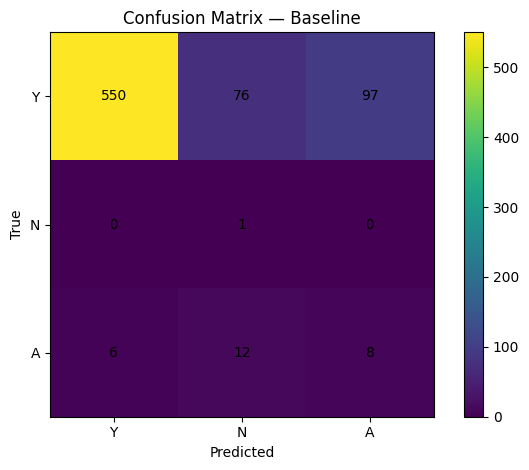

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

labels = ["Y", "N", "A"]

cm_base = confusion_matrix(df["Voting"], df["baseline_pred"], labels=labels)

plt.figure()
plt.imshow(cm_base)
plt.title("Confusion Matrix — Baseline")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)

for i in range(cm_base.shape[0]):
    for j in range(cm_base.shape[1]):
        plt.text(j, i, cm_base[i, j], ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.savefig("cm_baseline.png", dpi=200)
plt.show()

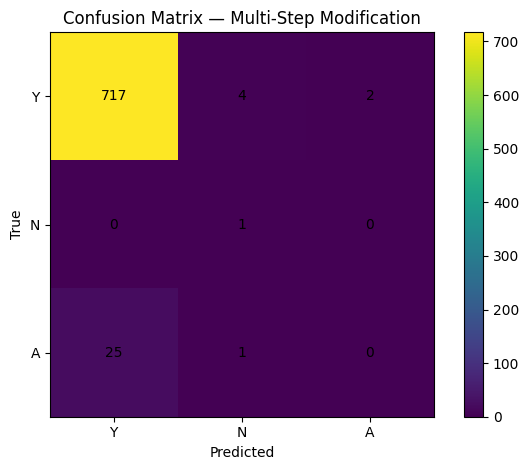

In [11]:
cm_mod = confusion_matrix(df["Voting"], df["mod_pred"], labels=labels)

plt.figure()
plt.imshow(cm_mod)
plt.title("Confusion Matrix — Multi-Step Modification")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)

for i in range(cm_mod.shape[0]):
    for j in range(cm_mod.shape[1]):
        plt.text(j, i, cm_mod[i, j], ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.savefig("cm_modification.png", dpi=200)
plt.show()

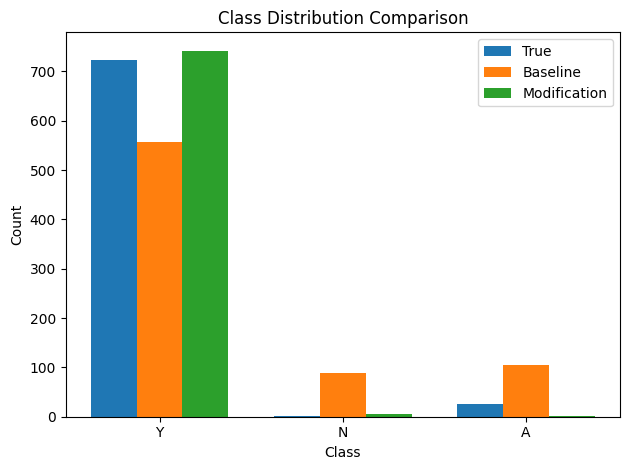

In [12]:
from collections import Counter

true_dist = Counter(df["Voting"])
base_dist = Counter(df["baseline_pred"])
mod_dist = Counter(df["mod_pred"])

x = np.arange(len(labels))
width = 0.25

plt.figure()
plt.bar(x - width, [true_dist.get(l, 0) for l in labels], width, label="True")
plt.bar(x,         [base_dist.get(l, 0) for l in labels], width, label="Baseline")
plt.bar(x + width, [mod_dist.get(l, 0) for l in labels], width, label="Modification")

plt.xticks(x, labels)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution Comparison")
plt.legend()
plt.tight_layout()
plt.savefig("class_distribution.png", dpi=200)
plt.show()

In [13]:
from sklearn.metrics import classification_report

print("Baseline:")
print(classification_report(df["Voting"], df["baseline_pred"]))

print("\nModification:")
print(classification_report(df["Voting"], df["mod_pred"]))

Baseline:
              precision    recall  f1-score   support

           A       0.08      0.31      0.12        26
           N       0.01      1.00      0.02         1
           Y       0.99      0.76      0.86       723

    accuracy                           0.75       750
   macro avg       0.36      0.69      0.33       750
weighted avg       0.96      0.75      0.83       750


Modification:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        26
           N       0.17      1.00      0.29         1
           Y       0.97      0.99      0.98       723

    accuracy                           0.96       750
   macro avg       0.38      0.66      0.42       750
weighted avg       0.93      0.96      0.94       750



In [ ]:

from sklearn.metrics import confusion_matrix

labels = ["Y","N","A"]
cm_base = confusion_matrix(df["Voting"], df["baseline_pred"], labels=labels)
cm_mod  = confusion_matrix(df["Voting"], df["mod_pred"], labels=labels)

recall_base = cm_base.diagonal() / cm_base.sum(axis=1)
recall_mod  = cm_mod.diagonal()  / cm_mod.sum(axis=1)

for i,l in enumerate(labels):
    print(l, "recall baseline:", recall_base[i], "recall mod:", recall_mod[i])

Y recall baseline: 0.7607192254495159 recall mod: 0.991701244813278
N recall baseline: 1.0 recall mod: 1.0
A recall baseline: 0.3076923076923077 recall mod: 0.0
